# TimeVAE

## Importamos las librerías y los VAEs

In [1]:
import os, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
warnings.filterwarnings('ignore') 

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disabling gpu usage because my cuda is corrupted, needs to be fixed. 


import numpy as np , pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from vae_dense_model import VariationalAutoencoderDense as VAE_Dense
from vae_conv_model import VariationalAutoencoderConv as VAE_Conv
from vae_conv_I_model import VariationalAutoencoderConvInterpretable as TimeVAE
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from pathlib import Path

## Path

In [2]:
results_path = Path('time_vae')
if not results_path.exists():
    results_path.mkdir()

In [3]:
experiment ='TFG'

In [4]:
log_dir = results_path / f'experiment_{experiment}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [5]:
hdf_store = results_path / 'TimeSeriesVAE.h5'

## Cargamos los datos

In [6]:
df = pd.read_hdf('data.h5', key='yfinance/data/real_data')
df.head()

,AAPL,MSFT,JNJ,AMZN,XOM,JPM,LQD,SHY,IEF,TLT,^GSPC,^DJI,^IXIC,GC=F,CL=F,IWM,FCEL,GBPUSD=X,JPY=X,EURUSD=X
Date,,,,,,,,,,,,,,,,,,,,
2003-12-01,0.387679,25.840000,49.500000,2.7325,36.389999,35.660000,109.389999,81.919998,83.599998,84.239998,1070.119995,9899.049805,1989.819946,402.700012,29.950001,55.430000,1977.119995,1.718597,109.169998,1.196501
2003-12-02,0.384643,25.660000,48.950001,2.6965,36.500000,35.810001,109.690002,82.010002,83.839996,84.599998,1066.619995,9853.639648,1980.069946,403.700012,30.780001,55.345001,1941.119995,1.730313,108.730003,1.208897
2003-12-03,0.375536,25.670000,49.160000,2.5755,36.540001,35.799999,109.500000,81.940002,83.620003,84.260002,1064.729980,9873.419922,1960.250000,403.899994,31.100000,54.349998,1951.199951,1.728101,108.300003,1.212298
2003-12-04,0.377679,26.200001,49.330002,2.5900,37.020000,35.389999,109.589996,82.019997,83.800003,84.449997,1069.719971,9930.820312,1968.800049,403.299988,31.260000,54.474998,1931.040039,1.720697,108.269997,1.208094
2003-12-05,0.372321,25.980000,49.160000,2.5780,36.779999,34.959999,110.730003,82.279999,84.820000,85.800003,1061.500000,9862.679688,1937.819946,406.399994,30.730000,53.799999,1877.760010,1.733102,107.620003,1.218695


In [7]:
# Determina el tamaño del conjunto de prueba
test_size = 0.2
split_index = int(len(df) * (1 - test_size))

# Divide el DataFrame en entrenamiento y prueba
train_df = df[:split_index]
test_df = df[split_index:]

In [8]:
df.shape

(5008, 20)

In [9]:
def select_data():
    df = pd.read_hdf('data.h5', 'yfinance/data/real_data')
    df.to_hdf(hdf_store, 'data/real')

In [10]:
select_data()

## Dibujamos los activos

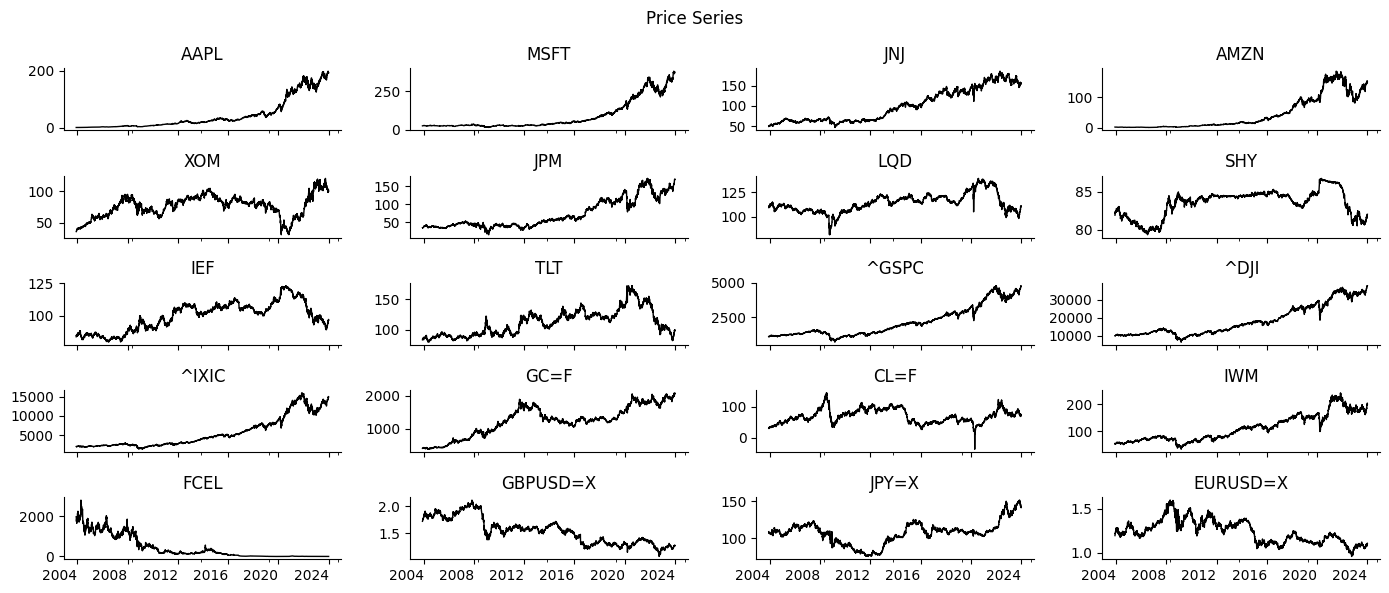

In [11]:
column_names = list(df.columns)
axes = df.plot(subplots=True,
                               figsize=(14, 6),
                               layout=(5, 4),
                               title=column_names,
                               legend=False,
                               rot=0,
                               lw=1, 
                               color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Price Series')
plt.gcf().tight_layout()
sns.despine();

## Matriz de Correlaciones

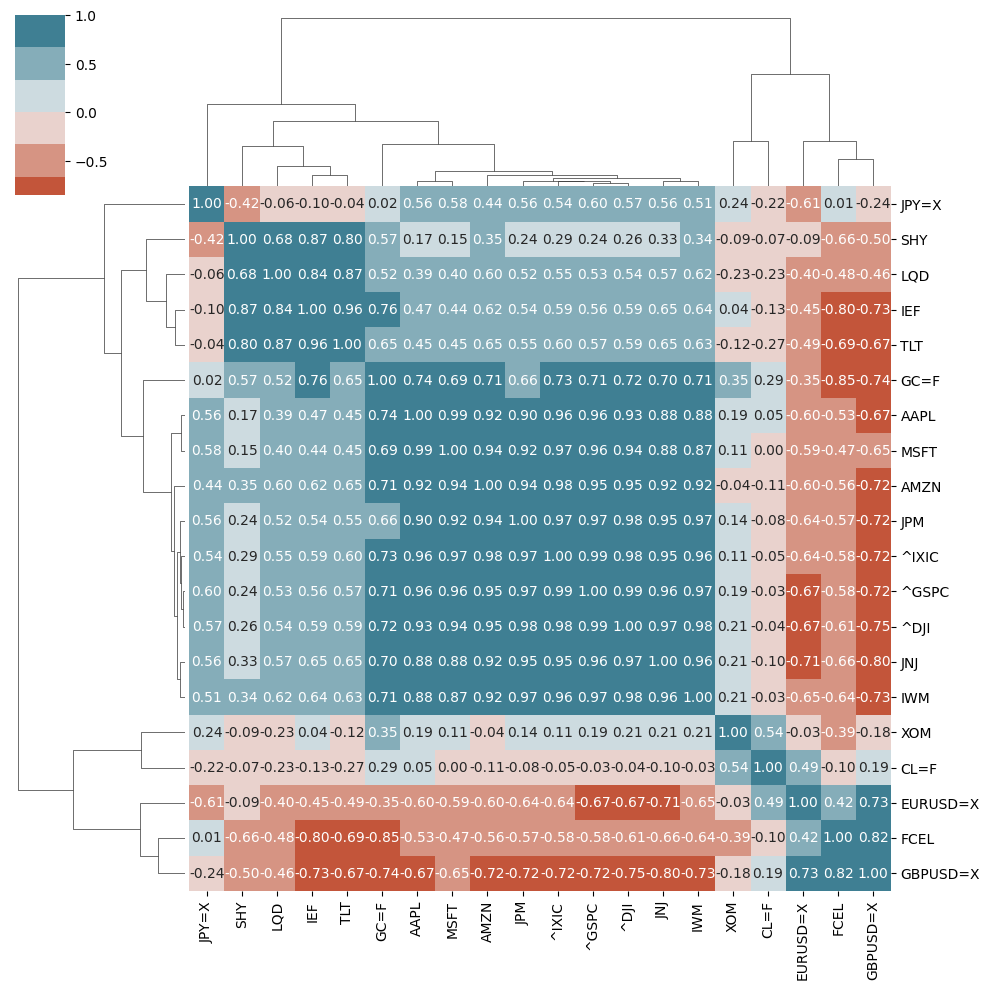

In [12]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

# Normalizamos datos

In [13]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_df).astype(np.float32)

## Creamos una Rolling Window

In [14]:
seq_len = 24
n_seq = 20
batch_size = 128

In [15]:
data= np.load('scaled_real_train_data_array.npy')
N, T, D = data.shape
N, T, D

(3982, 24, 20)

In [33]:
valid_data=np.load('real_test_data_array.npy')
scaled_valid_data=np.load('scaled_real_test_data_array.npy')

## Entrenamos el TimeVAE

In [17]:
vae_type = 'timeVAE'
latent_dim = 8

if vae_type == 'vae_dense': 
    vae = VAE_Dense( seq_len=T,  feat_dim = D, latent_dim = latent_dim, hidden_layer_sizes=[200,100], )
elif vae_type == 'vae_conv':
    vae = VAE_Conv( seq_len=T,  feat_dim = D, latent_dim = latent_dim, hidden_layer_sizes=[100, 200] )
elif vae_type == 'timeVAE':
    vae = TimeVAE( seq_len=T,  feat_dim = D, latent_dim = latent_dim, hidden_layer_sizes=[50, 100, 200],        #[80, 200, 250] 
            reconstruction_wt = 3.0,
            # ---------------------
            # disable following three arguments to use the model as TimeVAE_Base. Enabling will convert to Interpretable version.
            # Also set use_residual_conn= False if you want to only have interpretable components, and no residual (non-interpretable) component. 
            
             trend_poly=2, 
             custom_seas = [(7, 1)] * 20 ,     # list of tuples of (num_of_seasons, len_per_season)
             use_scaler = True,
            
            #---------------------------
            use_residual_conn = True
        )   
else:  raise Exception('wut')

In [18]:
vae.compile(optimizer=Adam(learning_rate=0.0001))
# vae.summary() ; sys.exit()

early_stop_loss = 'loss'
early_stop_callback = EarlyStopping(monitor=early_stop_loss, min_delta = 1e-1, patience=10) 
reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)

history=vae.fit(
    data, 
    batch_size = 32,
    epochs=500,
    shuffle = True,
    callbacks=[early_stop_callback, reduceLR],
    verbose = 1)

Epoch 1/500
125/125 [==============================] - 4s 8ms/step - loss: 13066.3738 - reconstruction_loss: 2615.4282 - kl_loss: 137.5285 - lr: 1.0000e-04
Epoch 2/500
125/125 [==============================] - 1s 8ms/step - loss: 2139.5155 - reconstruction_loss: 514.8314 - kl_loss: 417.9009 - lr: 1.0000e-04
Epoch 3/500
125/125 [==============================] - 1s 8ms/step - loss: 1410.3850 - reconstruction_loss: 252.8956 - kl_loss: 458.4919 - lr: 1.0000e-04
Epoch 4/500
125/125 [==============================] - 1s 7ms/step - loss: 926.1446 - reconstruction_loss: 150.1206 - kl_loss: 443.6096 - lr: 1.0000e-04
Epoch 5/500
125/125 [==============================] - 1s 7ms/step - loss: 827.6866 - reconstruction_loss: 127.7669 - kl_loss: 427.3572 - lr: 1.0000e-04
Epoch 6/500
125/125 [==============================] - 1s 7ms/step - loss: 774.0378 - reconstruction_loss: 111.6122 - kl_loss: 420.9975 - lr: 1.0000e-04
Epoch 7/500
125/125 [==============================] - 1s 7ms/step - loss: 72

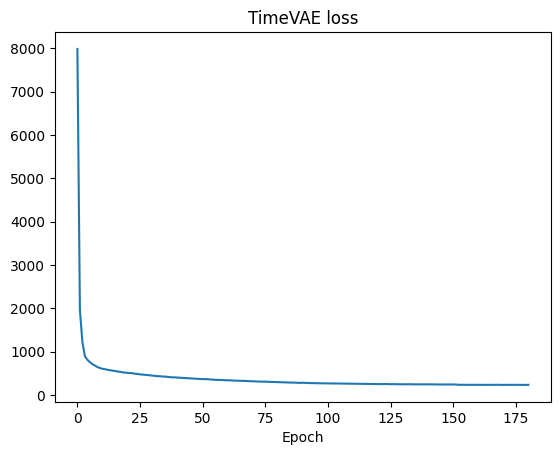

In [19]:
plt.plot(history.history['loss'],label='try')
plt.title('TimeVAE loss')
plt.xlabel('Epoch')
plt.show()
plt.close()

In [20]:
vae.save(model_dir=log_dir, file_pref='vae_model')

## Visualización

125/125 [==============================] - 1s 4ms/step
x_decoded.shape (3982, 24, 20)


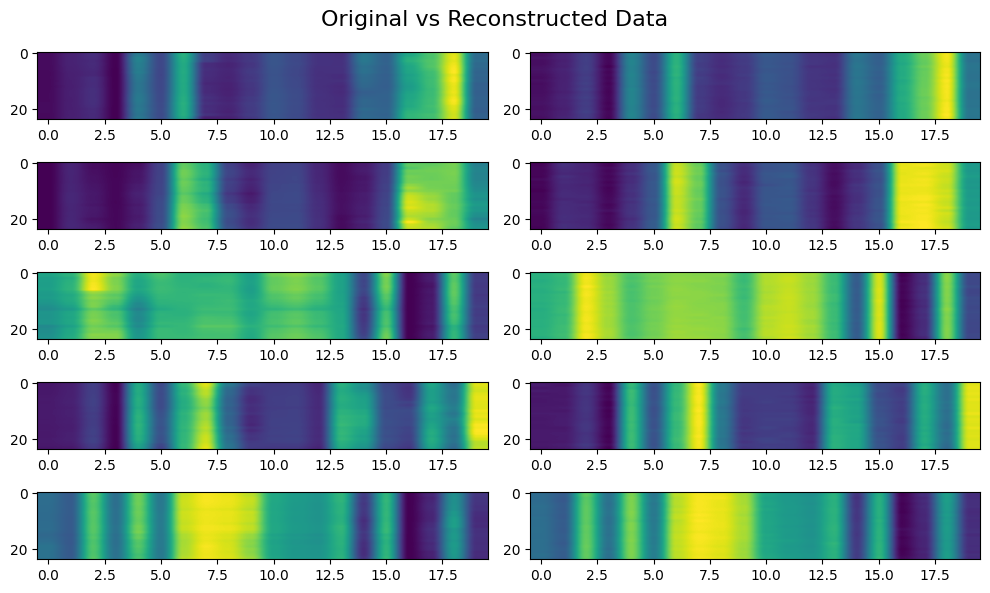

In [21]:
X = data
x_decoded = vae.predict(data)
print('x_decoded.shape', x_decoded.shape)
utils.draw_orig_and_post_pred_sample(X, x_decoded, n=5)

## Datos Originales vs Reconstruidos. Datos de Entrenamiento

In [46]:
def get_rolling_window(df,seq_len):
    data = []
    for i in range(len(df) - seq_len):
        data.append(np.array(df)[i:i + seq_len])

    n_windows = len(data)
    data=np.array(data)
    return data, n_windows


In [47]:
def reconstruct_data(data, df):
    reconstructed_data = []

    # Reconstruct the data
    for i in range(len(data)):
        if i == 0:
            # For the first window, take all values
            reconstructed_data.append(data[i])
        else:
            # For subsequent windows, append only the last value (to avoid overlap)
            reconstructed_data.append(data[i][-1:])

    # Flatten the list of arrays into a single array
    reconstructed_data = np.vstack(reconstructed_data)
    if reconstructed_data.shape[0]<df.shape[0]:
        reconstructed_data = np.append(reconstructed_data, df.tail(1).values, axis=0)
    # Create a DataFrame
    reconstructed_df = pd.DataFrame(reconstructed_data, columns=df.columns)
    return reconstructed_df

In [48]:
prediction=vae.predict(data)
prediction_aux=reconstruct_data(data=prediction,df=train_df)
prediction_aux.shape

125/125 [==============================] - 1s 4ms/step


(4006, 20)

In [49]:
original_data=get_rolling_window(train_df,seq_len)[0]
original_data.shape

(3982, 24, 20)

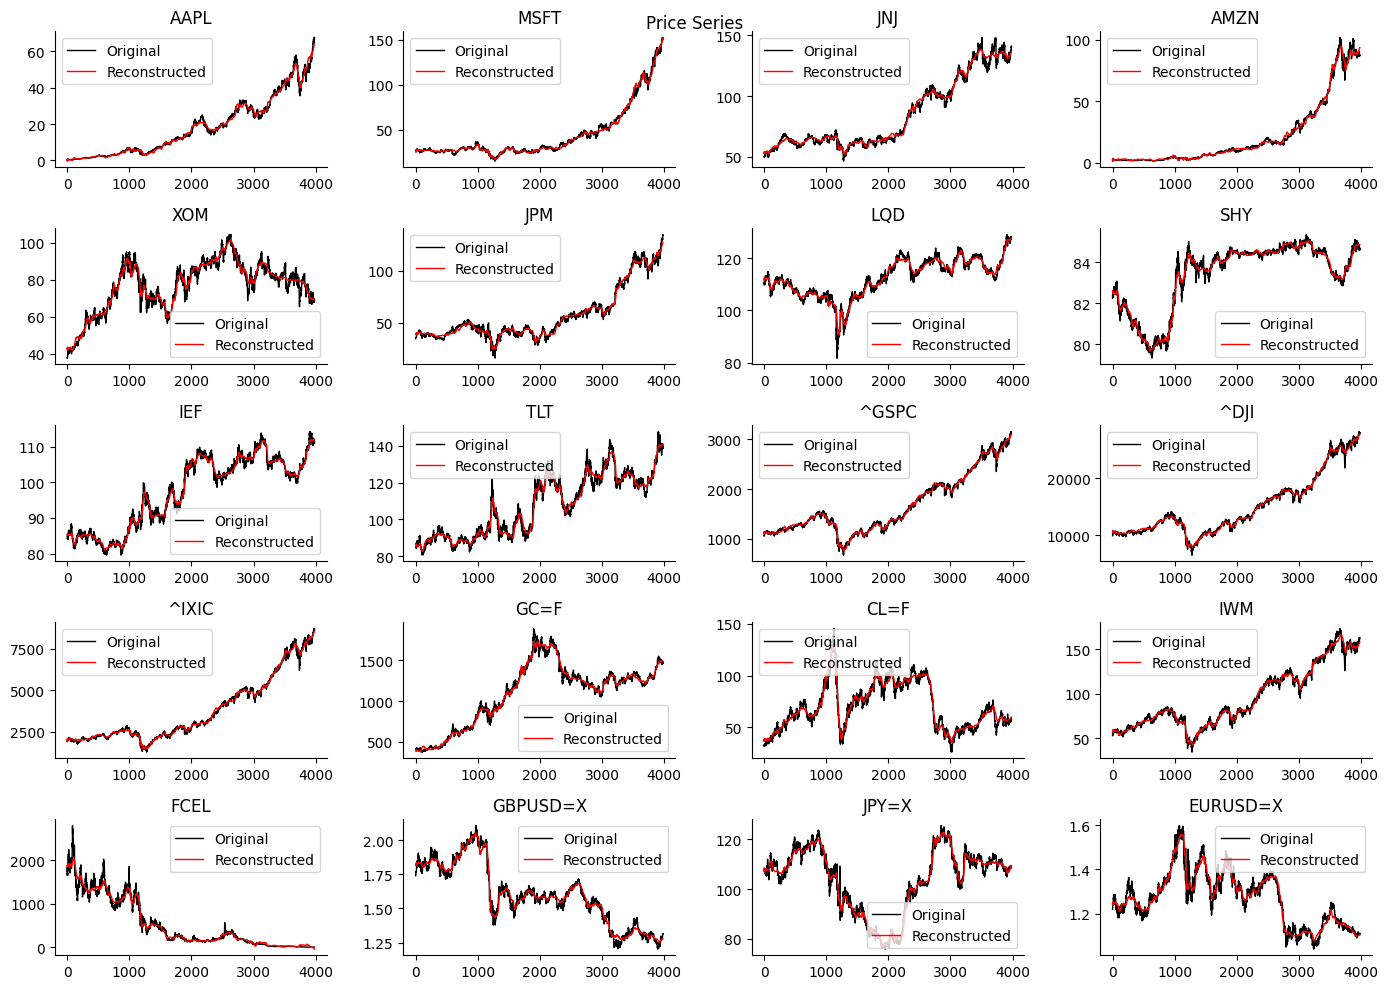

<Figure size 640x480 with 0 Axes>

In [50]:
i=7
train_data=pd.DataFrame(original_data[:,i,:], columns=column_names)
x_decoded = scaler.inverse_transform(prediction_aux)
x_decoded_aux=get_rolling_window(x_decoded,seq_len)[0]
x_decoded=pd.DataFrame(x_decoded_aux[:,i,:], columns=column_names)

# Create figure and axes
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 10))

# Flatten the axes array
axes = axes.flatten()

# Iterate over each column in the DataFrame
for i, col in enumerate(train_data.columns):
    # Plot original data
    train_data[col].plot(ax=axes[i], color='k', lw=1, label='Original')
    
    # Plot reconstructed data
    x_decoded[col].plot(ax=axes[i], color='r', lw=1, label='Reconstructed')
    
    # Set title for the subplot
    axes[i].set_title(col)
    
    # Remove xlabel
    axes[i].set_xlabel('')
    
    # Show legend
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Set overall title
plt.suptitle('Price Series')

# Remove spines
sns.despine()

# Show plot
plt.show()
plt.savefig('reconstruccion_train_vae.png')

# Datos Originales vs Reconstruidos. Datos de Test

In [53]:
valid_data=np.load('real_test_data_array.npy')
scaled_valid_data=np.load('scaled_real_test_data_array.npy')

In [54]:
prediction=vae.predict(scaled_valid_data)
prediction_aux=reconstruct_data(data=prediction,df=train_df)
prediction_aux.shape

31/31 [==============================] - 0s 5ms/step


(1002, 20)

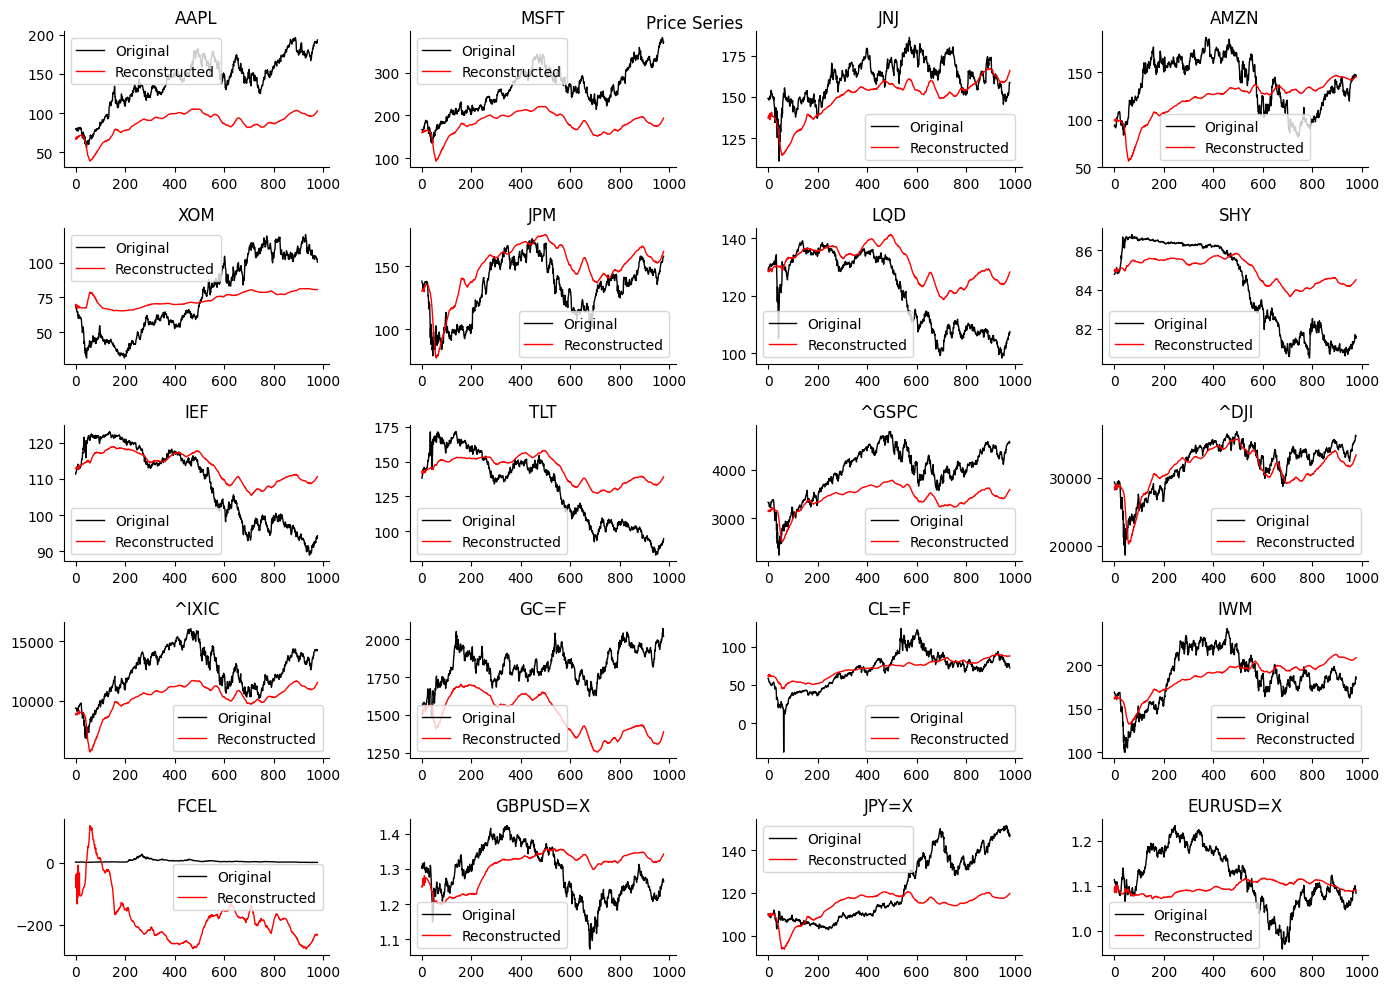

<Figure size 640x480 with 0 Axes>

In [55]:
i=7
valid_data=pd.DataFrame(valid_data[:,i,:], columns=column_names)
x_decoded = scaler.inverse_transform(prediction_aux)
x_decoded_aux=get_rolling_window(x_decoded,seq_len)[0]
x_decoded=pd.DataFrame(x_decoded_aux[:,i,:], columns=column_names)


# Create figure and axes
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 10))

# Flatten the axes array
axes = axes.flatten()

# Iterate over each column in the DataFrame
for i, col in enumerate(valid_data.columns):
    # Plot original data
    valid_data[col].plot(ax=axes[i], color='k', lw=1, label='Original')
    
    # Plot reconstructed data
    x_decoded[col].plot(ax=axes[i], color='r', lw=1, label='Reconstructed')
    
    # Set title for the subplot
    axes[i].set_title(col)
    
    # Remove xlabel
    axes[i].set_xlabel('')
    
    # Show legend
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Set overall title
plt.suptitle('Price Series')

# Remove spines
sns.despine()

# Show plot
plt.show()
plt.savefig('reconstruccion_test_vae.png')

## Generación de Datos Sintéticos

In [36]:
generated_data=vae.get_prior_samples(4984)
generated_data.shape

156/156 [==============================] - 1s 3ms/step


(4984, 24, 20)

In [37]:
np.save(log_dir / 'generated_data_vae.npy', generated_data)

In [38]:
np.save('scaled_synthetic_data_array_vae.npy', generated_data)

In [39]:
scaler2 = MinMaxScaler()
scaled_data = scaler2.fit_transform(train_df).astype(np.float32)

In [40]:
generated_data = (scaler2.inverse_transform(generated_data
                                           .reshape(-1, 20))
                  .reshape(-1, seq_len, 20))
generated_data.shape

(4984, 24, 20)

In [41]:
np.save('synthetic_data_array_vae.npy', generated_data)

In [43]:
tickers=['AAPL', 'MSFT','JNJ', 'AMZN','XOM', 'JPM', 'LQD', 'SHY','IEF', 'TLT','^GSPC', 
         '^DJI', '^IXIC', 'GC=F', 'CL=F','IWM','FCEL', 'GBPUSD=X', 'JPY=X', 'EURUSD=X']

In [44]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic3', pd.DataFrame(generated_data.reshape(-1, 20),
                                             columns=tickers))

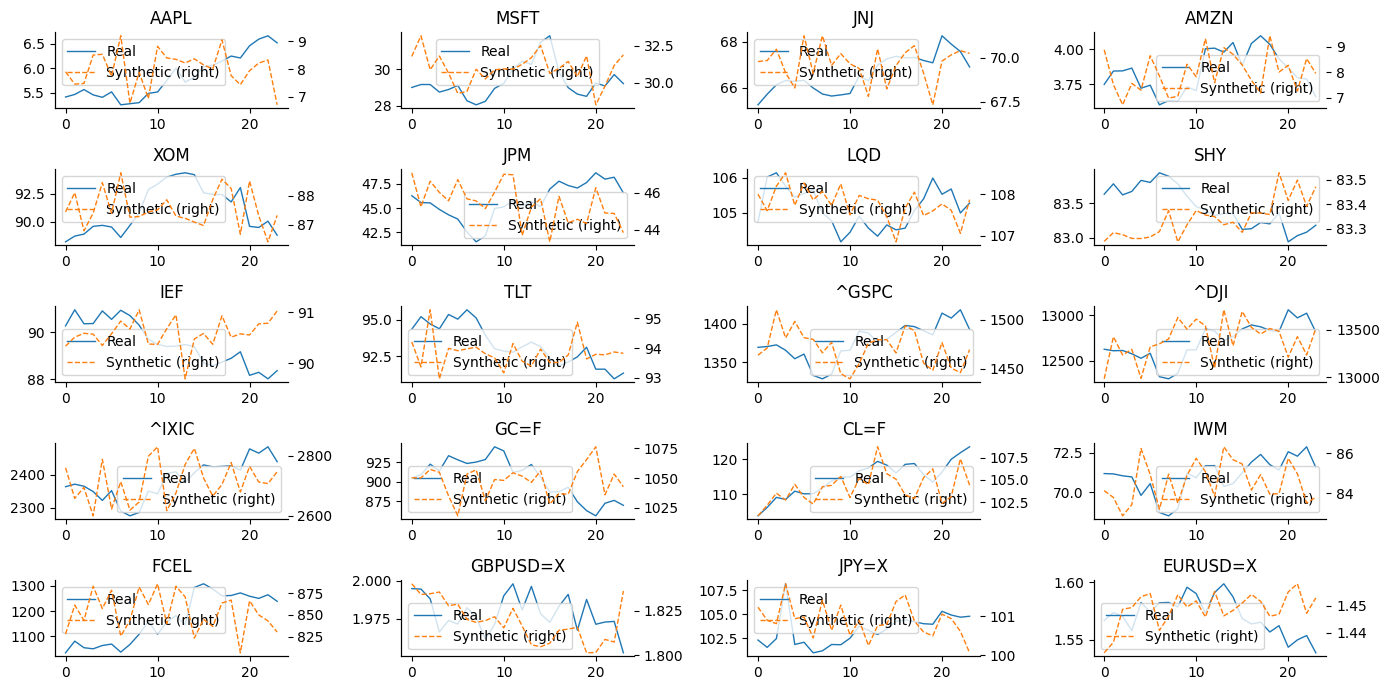

In [45]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(generated_data.shape[0])]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()
plt.savefig('distribucion_vae.png')